In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
from matplotlib.patches import ArrowStyle

# Export all the data

In [8]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import os

###################################
#             Configs 
###################################

logs_dir = "Results/"
output_path = "Results/tb_logs/"

list_tags = ["Avg_Ep/G", "Avg_Ep/G/Pixel_Loss"]
list_output_tags  = ["-G_Loss", "-Px_Loss"]
verbose = 1

###################################


print ("------------- \n    Saved     \n------------- ")

os.makedirs(output_path, exist_ok = True)
dropped = []

for log in os.listdir(logs_dir): 
    # print (log)
    printlist = []
    try: 
        event_accumulator = EventAccumulator(logs_dir + log + "/Logs")
        event_accumulator.Reload()
        
        for tag, output_tag in zip(list_tags, list_output_tags):
            #
            #tags = event_accumulator.Tags(); print (tags)
            events = event_accumulator.Scalars(tag); 
            x = [x.step for x in events]
            y = [x.value for x in events]
            name = log [:log.find("_")] + output_tag + ".csv"
            #name = log [: log.rfind("-0")] + output_tag + ".csv"

            df = pd.DataFrame({"Step": x, "Value": y})
            df.to_csv(output_path + name, index=False) 
            printlist.append(name) #print (output_path + name)
    except Exception as ex: 
        if   verbose == 0: 
            dropped.append("--> [!] Dropped: {0}".format(log))
        elif verbose == 1: 
            dropped.append("--> [!] Dropped: {0} \n\tLog: {1}".format(log, ex))
    print ("for {0}, saved: {1}".format(log, printlist))

            
print()
print ("------------- ")

if dropped: 
    for d in dropped: print(d)
    


------------- 
    Saved     
------------- 
for gan_cs, saved: ['gan-G_Loss.csv', 'gan-Px_Loss.csv']
for tb_logs, saved: []
for unet_cs, saved: ['unet-G_Loss.csv', 'unet-Px_Loss.csv']

------------- 
--> [!] Dropped: tb_logs 
	Log: Directory Results/tb_logs/Logs has been permanently deleted


# Comparative Plots

##### Smoothing

In [1]:
from typing import Sequence
from copy import copy

def smoothing(arr: Sequence, smooth: float = 0.9) -> Sequence:
    arr = copy(arr)
    weight = smooth  # 
    for i in range(1, len(arr)):
        arr[i] = (arr[i - 1] * weight + arr[i]) / (weight + 1)
        weight = (weight + 1) * smooth  # `* smooth`
    return arr

## UNet vs GAN

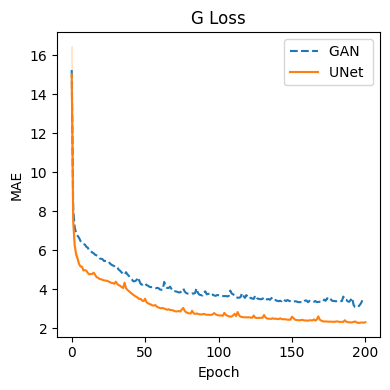

In [6]:
logs_path = "Results/tb_logs/"

prefix = ""
tag = "-G_Loss.csv"


save_fig = False
name_fig = "Results/figures/GANvsUNet_GLoss.png"
verbose = 1

list_logs = [prefix+"gan"  + tag,
             prefix+"unet" + tag,]

list_labels = ["GAN ", 
               "UNet ", ]

list_styles = ["--"  , 
               "-" , 
               "-." , 
               "-." ,]



dropped = []
fig, ax = plt.subplots(figsize = (4,4))

for file, label, line in zip(list_logs, list_labels, list_styles): 
    #
    try: 
        data = pd.read_csv (logs_path + file)
        data.Value = smoothing(data.Value, 0.1)
        sns.lineplot (data = data, x = "Step", y = "Value", ax = ax, linestyle = line, label = label)
    except Exception as ex: 
        if   verbose == 0: 
            dropped.append("--> [!] Dropped: {0}".format(file))
        elif verbose == 1: 
            dropped.append("--> [!] Dropped: {0} \n\tLog: {1}".format(file, ex))
        

if dropped: 
    print ("------------- ")
    for d in dropped: print(d)


ax.set_title ("G Loss") #labels = list_labels
#plt.ylim((5,10))
#plt.xlim((-10,500))

ax.set_ylabel("MAE")
ax.set_xlabel("Epoch")
plt.tight_layout()
if save_fig: 
    plt.savefig (name_fig, bbox_inches = "tight", dpi = 150)

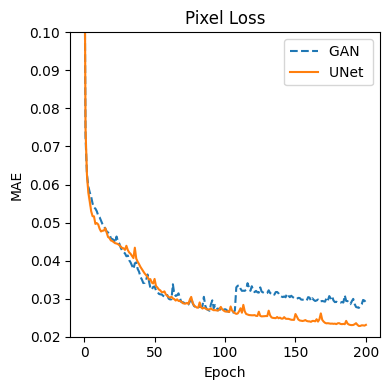

In [7]:
logs_path = "Results/tb_logs/"

prefix = ""
tag = "-Px_Loss.csv"


save_fig = False
name_fig = "Results/figures/GANvsUNet_PxLoss.png"
verbose = 1

list_logs = [prefix+"gan"  + tag,
             prefix+"unet" + tag,]

list_labels = ["GAN ", 
               "UNet ", ]

list_styles = ["--"  , 
               "-" , 
               "-." , 
               "-." ,]



dropped = []
fig, ax = plt.subplots(figsize = (4,4))

for file, label, line in zip(list_logs, list_labels, list_styles): 
    #
    try: 
        data = pd.read_csv (logs_path + file)
        data.Value = smoothing(data.Value, 0.1)
        sns.lineplot (data = data, x = "Step", y = "Value", ax = ax, linestyle = line, label = label)
    except Exception as ex: 
        if   verbose == 0: 
            dropped.append("--> [!] Dropped: {0}".format(file))
        elif verbose == 1: 
            dropped.append("--> [!] Dropped: {0} \n\tLog: {1}".format(file, ex))
        

if dropped: 
    print ("------------- ")
    for d in dropped: print(d)


ax.set_title ("Pixel Loss") #labels = list_labels
plt.ylim((0.02,0.10))
#plt.xlim((-10,500))

ax.set_ylabel("MAE")
ax.set_xlabel("Epoch")
plt.tight_layout()
if save_fig: 
    plt.savefig (name_fig, bbox_inches = "tight", dpi = 150)

# Stats

In [26]:
from ctypes import alignment
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_stats (stats_, key, ax, metric="psnr", title="def"):
    #
    for i, name_exp in enumerate(stats_["name_exp"]):
        if not key in name_exp:
            stats_ = stats_.drop(i)

    label_name = [plt.Text(i,0,name[name.find("/")+1:name.rfind("/")]) for i,name in enumerate(stats_["name_exp"])]
    #print(stats_fim)

    #_, ax = plt.subplots(figsize = (6,5))
    sns.set(font_scale=1.4)
    sns.barplot(data=stats_, x="Model", y=metric, hue="CE", palette = 'mako', ax=ax)
    #plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    ax.set_title(metric.upper() + " - " + title), #ax.set_ylim(0,0.2)
    ax.legend(loc="lower right")
    ax.set_axisbelow(True)
    ax.grid(linestyle='--', linewidth=1, zorder=0)

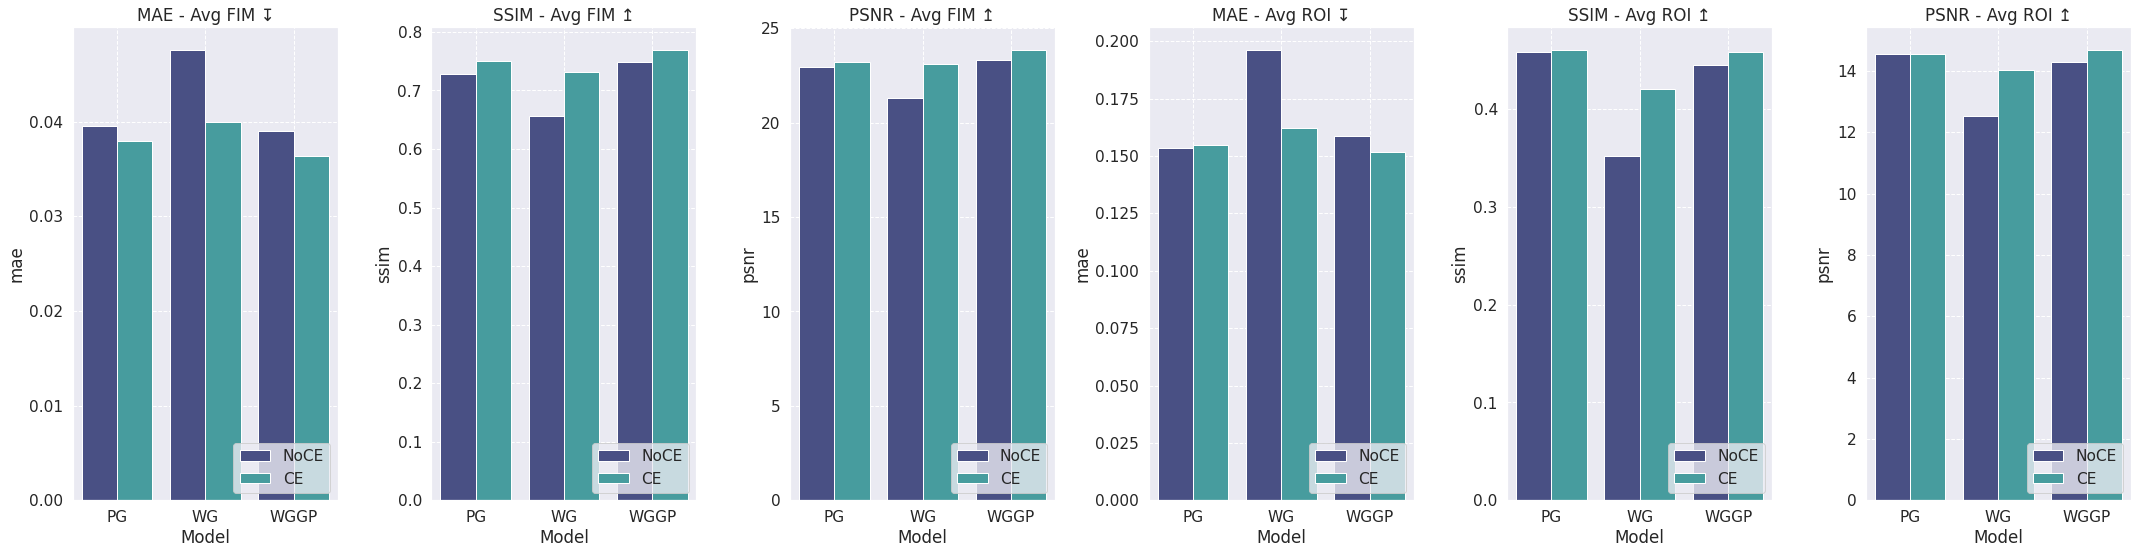

In [31]:
# stats = pd.read_csv("Results/exp_2/stats_exp2.csv")
stats = pd.read_csv("Results/stats.csv")
save_fig = False
name_fig = "Results/figures_exp2/exp2_mae_ssim_psnr.png"

#key = "avg_fim" #"avg_fim" "avg_roi" 

stats_fim = stats.copy()
stats_roi = stats.copy()
num_figs = 3

_, axes = plt.subplots(1, 2*num_figs,figsize = (30,8))
axes = axes.ravel()

plot_stats (stats_fim, "avg_fim", axes[0], metric="mae", title="Avg FIM ↧")
plot_stats (stats_roi, "avg_roi", axes[0+num_figs], metric="mae", title="Avg ROI ↧")

plot_stats (stats_fim, "avg_fim", axes[1], metric="ssim", title="Avg FIM ↥")
plot_stats (stats_roi, "avg_roi", axes[1+num_figs], metric="ssim", title="Avg ROI ↥")

plot_stats (stats_fim, "avg_fim", axes[2], metric="psnr", title="Avg FIM ↥")
plot_stats (stats_roi, "avg_roi", axes[2+num_figs], metric="psnr", title="Avg ROI ↥")


plt.tight_layout()
if save_fig: 
    plt.savefig (name_fig, bbox_inches = "tight", dpi = 150)


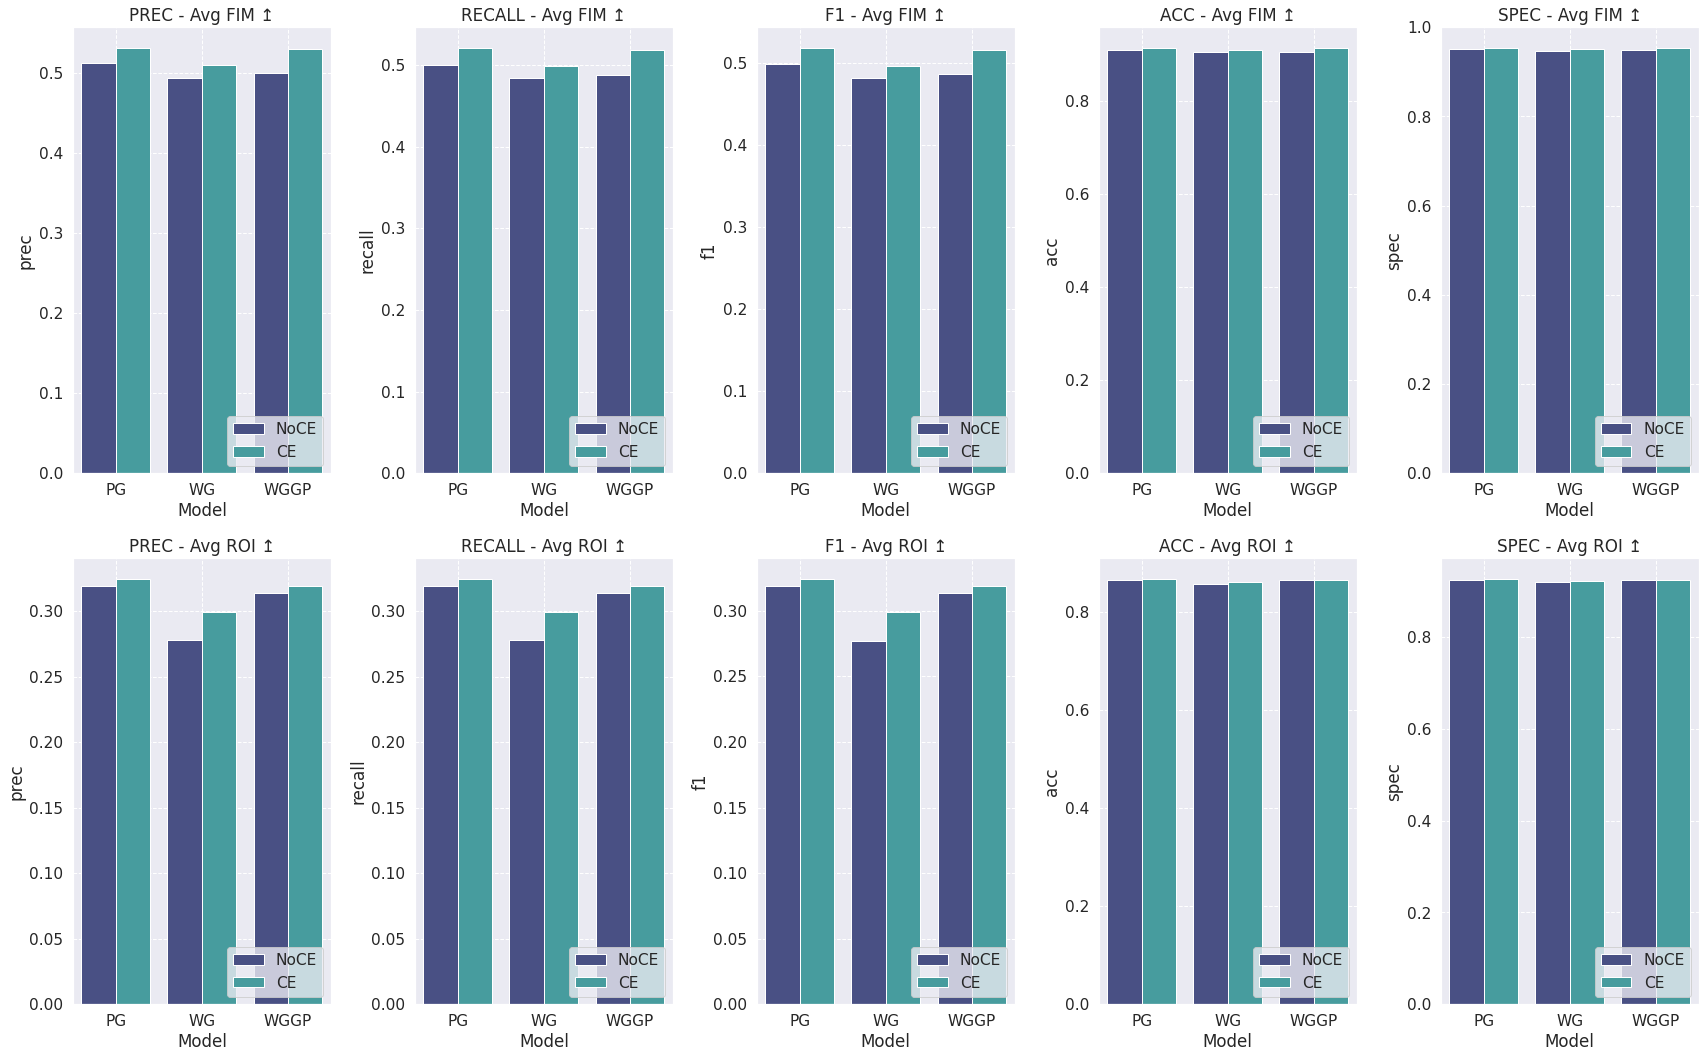

In [32]:
# stats = pd.read_csv("Results/exp_2/stats_exp2.csv")
stats = pd.read_csv("Results/stats.csv")
save_fig = False
name_fig = "Results/figures_exp2/exp2_class.png"


#key = "avg_fim" #"avg_fim" "avg_roi" 

stats_fim = stats.copy()
stats_roi = stats.copy()

num_figs = 5

_, axes = plt.subplots(2,num_figs,figsize = (24,15))
axes = axes.ravel()

#prec,recall,f1,acc,spec,
plot_stats (stats_fim, "avg_fim", axes[0], metric="prec", title="Avg FIM ↥")
plot_stats (stats_roi, "avg_roi", axes[0+num_figs], metric="prec", title="Avg ROI ↥")

plot_stats (stats_fim, "avg_fim", axes[1], metric="recall", title="Avg FIM ↥")
plot_stats (stats_roi, "avg_roi", axes[1+num_figs], metric="recall", title="Avg ROI ↥")

plot_stats (stats_fim, "avg_fim", axes[2], metric="f1", title="Avg FIM ↥")
plot_stats (stats_roi, "avg_roi", axes[2+num_figs], metric="f1", title="Avg ROI ↥")

plot_stats (stats_fim, "avg_fim", axes[3], metric="acc", title="Avg FIM ↥")
plot_stats (stats_roi, "avg_roi", axes[3+num_figs], metric="acc", title="Avg ROI ↥")

plot_stats (stats_fim, "avg_fim", axes[4], metric="spec", title="Avg FIM ↥")
plot_stats (stats_roi, "avg_roi", axes[4+num_figs], metric="spec", title="Avg ROI ↥")


plt.tight_layout()
if save_fig: 
    plt.savefig (name_fig, bbox_inches = "tight", dpi = 150)

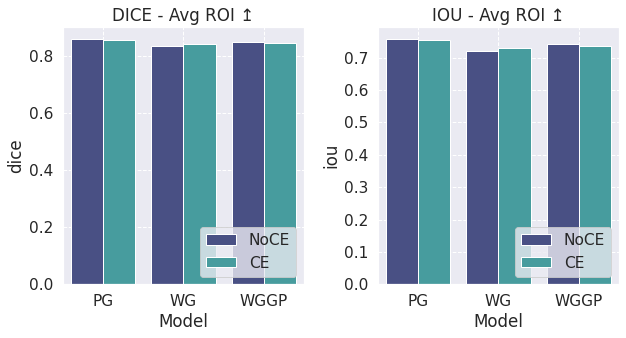

In [33]:
# stats = pd.read_csv("Results/exp_2/stats_exp2.csv")
stats = pd.read_csv("Results/stats.csv") 
save_fig = False
name_fig = "Results/figures_exp2/exp2_dice_iou.png"


#key = "avg_fim" #"avg_fim" "avg_roi" 

stats_fim = stats.copy()
stats_roi = stats.copy()

_, axes = plt.subplots(1,2,figsize = (9,5))
axes = axes.ravel()

#plot_stats (stats_fim, "avg_fim", axes[0], metric="dice")
plot_stats (stats_roi, "avg_roi", axes[0], metric="dice", title="Avg ROI ↥")

#plot_stats (stats_fim, "avg_fim", axes[2], metric="iou")
plot_stats (stats_roi, "avg_roi", axes[1], metric="iou", title="Avg ROI ↥")

plt.tight_layout()
if save_fig: 
    plt.savefig (name_fig, bbox_inches = "tight", dpi = 150)

In [42]:
import os
import pandas as pd
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt

# stats = pd.read_csv("Results/exp_2/stats_exp2.csv")
#path = "/home/ruben-kubuntu/Devs/exps_2/cgan/Results/exp3D/" 
path = "/home/ruben-kubuntu/Devs/exps_2/cgan/Results/exp_F/" 
prefix = "d2-d5_" #p1-p3_
list_exps = [prefix + "PG", prefix + "PG_CA", 
             prefix + "WG", prefix + "WG_CA" ,
             prefix + "WGGP", prefix + "WGGP_CA"]

names = {"PG" : "PatchGAN", "WG" : "WGAN", "WGGP_CA" : "WGAN-GP + CE",
         "WGGP" : "WGAN-GP", "WG_CA" : "WGAN + CE", "PG_CA" : "PatchGAN + CE"}
img_id = "144.png" #"10.png" # "200.png"
#"10.png" "70.png" "85.png" "144.png" "151.png"

for id in range (140, 150, 1):
    _, axes = plt.subplots(6,1, figsize = (8,16)); axes=axes.ravel()
    
    img_id = str(id) + ".png"
    i = 0
    for exp in list_exps:
        if os.path.isdir (path+exp): 
            #print (exp) #, "-", names[exp[6:]])
            expn = "ep_100" if exp == prefix + "WG_CAd" else "ep_200"
            image = Image.open(path+exp+"/generated_images/" + expn + "/imgs/"+ img_id)#.convert("L")
            axes[i].imshow(image, vmin=-1, vmax=1); axes[i].set_axis_off()
            axes[i].set_title(names[exp[6:]]); i += 1

    plt.tight_layout()
    #plt.savefig ("Results/figures_exp3D/stats/"+img_id, bbox_inches = "tight", dpi = 150)
    plt.savefig ("Results/figures_expF/stats/"+img_id, bbox_inches = "tight", dpi = 150)
    plt.close(), plt.clf()
# plt.show()

<Figure size 432x288 with 0 Axes>